МФТИ ФИВТ: Курс Машинное Обучение (осень, 2016), Арсений Ашуха, ars.ashuha@gmail.com

<h1 align="center">Organization Info</h1> 

**Дополнительный материал для выполнения дз**:
- Hastie, The Elements of Statistical Learning, https://goo.gl/k3wfEU, 10 Boosting and Additive Trees 337
- Соколов, Семинары по композиционным методам, https://goo.gl/sn8RyJ, http://goo.gl/ajNTQy

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2016_fall <номер_группы> <фамилия>``, к примеру -- ``ML2016_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2016_fall Question <Содержание вопроса>``

--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было 

<h1 align="center">Check Questions</h1> 

материалы: https://github.com/esokolov/ml-course-msu/tree/master/ML15-spring/lecture-notes

Ответе на вопросы своими словами (загугленный материал надо пересказать), ответ обоснуйте (напишите и ОБЪЯСНИТЕ формулки если потребуется), если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1**: Чем отличается AdaBoost от XGBoost? Перечислите принципиальные отличия. 

AdaBoost не может оценивать вероятности классов. В XGBoost мы уменьшаем не функцию потерь, а среднеквадратичное отклонение от ее антиградиента (см. вопрос 3). Во втором алгоритме есть регуляризация. И, наконец, последнее: при построении дерева в XGBoost-e используется критерий, которые зависит от оптимального вектора сдвига (см. вопрос 3)

**Вопрос 2**: Почему говорят, что AdaBoost неустойчив к выбросам?

В данном алгоритме используется экспоненциальная функция потерь, которая дает очень большой штраф на объектах с очень маленьким отступом. Как следствие, алгоритм фокусируется на выбросах, что не есть хорошо.

**Вопрос 3**:  В каком пространстве градиентный бустинг совершает градиентный спуск? Какова размерность этого пространства?

В пространстве предсказаний алгоритма на объектах обучающей выборки. Размерность данного пространства равна количеству сэмплов в трейне.

**Вопрос 4**: В чем заключается сокращение шага в градиентном бустинге? Как число итераций, необходимое для сходимости, зависит от размера шага η?

Здесь $0 < \eta \le 1$. Суть в том, что вес каждого нового алгоритма в композиции мы умножаем на $\eta$, тем самым делая уменьшеный шаг в сторону антиградиента функции потерь. При этом, чем меньше $\eta$, тем большее количество итераций необходимо для настройки градиентного бустинга.

**Вопрос 5**: Что такое стохастический градиентный бустинг?

Градиентный бустинг, в котором каждый новый алгоритм обучается не на всей выборке, а на ее случайной подвыборке. Это понижает уровень шума при обучении и время обучения нового алгоритма.

-----------
PS: Если проверяющий не понял ответ на большинство вопросов, то будет пичалька. Пишите так, чтобы можно было разобраться. 

<h1 align="center">Boosting</h1> 

** 1) Задача 1 **
![](./img/task11.png)
![](./img/task12.png)

Хотелось бы иметь $b_n = I(x = x_n)$, тогда $\gamma_n = y_n$. Как известно, любой индикатор равенства можно представить, как разность двух индикаторов с неравенствами. Т.е. $I(x = x_n) = I(x \le x_n) - I(x < x_n)$. Собственно возьмем
$b_n(x) = I(x \le x_n), b_{n + l}(x) = I(x < x_n), n \in \{1..l\}; ~~~ \gamma_n = \gamma_{n + l} = y_n$

В этой композиции $2l$ алгоритмов, что меньше, чем $2l + 2$

** 2) Задача 2** 

Найдите градиент логистичиской функции потерь для фиксированного объекта

$L(x,y) = \ln (1 + e^{-y y'})$, где $y'$ - ответ алгоритма на объекте $x$. 
$\Rightarrow$
$\frac{\partial}{\partial y'}L(x,y) = \frac{-ye^{-y y'}}{(1 + e^{-y y'})}$

<h1 align="center">Binary Boosting Implementation</h1> 

Нужно реализовать двухклассовый бустинг с логистичиской функцией потерь. 

Длину шага -- или используйте $1.0*lr$ или подбирайте одномерной оптимизацией;

In [1]:
%pylab inline
%reload_ext autoreload
%autoreload 2
import warnings
import numpy as np
import pandas as pd
import re
from copy import deepcopy
from utils import plot_surface
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.ensemble import GradientBoostingClassifier
from scipy.optimize import minimize_scalar
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection

warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
class BinaryBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators, lr=0.1):
        self.lr = lr   
        self.n_estimators = n_estimators
    
    def loss_grad(self, original_y, pred_y):
        return -original_y * np.exp(-original_y * pred_y) / (1 + np.exp(-original_y * pred_y))
    
    def loss_mse_(self, gamma, original_y, prev_step_ans, cur_step_ans):
        return np.sum((prev_step_ans  + gamma * cur_step_ans - original_y) ** 2)
        
    def fit(self, X, original_y):
        # Храните базовые алгоритмы тут
        self.estimators_ = []
        self.coeffs_ = []
        
        prev_step_ans = np.ones(original_y.shape[0])
        
        for i in range(self.n_estimators):
            estimator = DecisionTreeRegressor()
            grad = self.loss_grad(original_y, prev_step_ans)
            # Настройте базовый алгоритм на градиент, это классификация или регрессия?
            estimator.fit(X, -grad)
            cur_step_ans = estimator.predict(X)
            
            gamma = self.lr * minimize_scalar(self.loss_mse_, args=(original_y, prev_step_ans, cur_step_ans)).x
            self.estimators_.append(estimator)
            self.coeffs_.append(gamma)
            prev_step_ans += gamma * cur_step_ans
            
        
        self.out_ = self.outliers(grad)

        return self

    def _predict(self, X):
        answers = np.vstack(np.vectorize(lambda est, x: est.predict(x), excluded={'x'}, 
                                         otypes=[np.ndarray])(self.estimators_, x=X)).T
        y_pred = np.sum(np.array(self.coeffs_) * answers, axis=1)
        return y_pred
    
    def predict(self, X):
        y_pred = 2 * (self._predict(X) > 0) - 1
        return y_pred
    
    def outliers(self, grad):
        return np.abs(grad).argsort()[-10:]

<h1 align="center">Simple test</h1> 

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)
y = 2*(y-0.5)

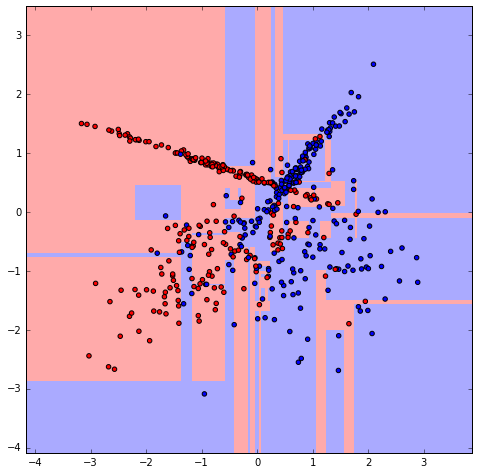

In [4]:
clf = BinaryBoostingClassifier(n_estimators=100).fit(X, y)
y_pred = clf.predict(X)
plot_surface(X, y, clf)

<h1 align="center">Outliers</h1> 

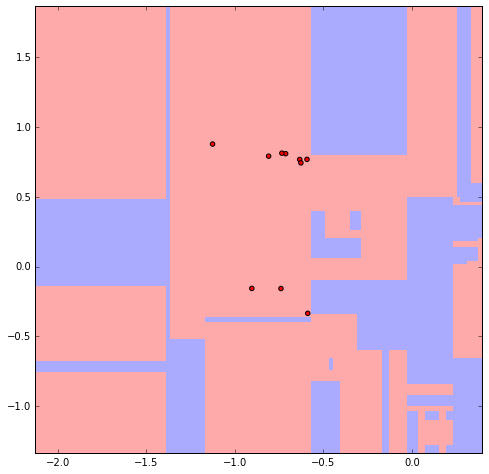

In [5]:
indexes = clf.out_
plot_surface(X[clf.out_], y[clf.out_], clf)

<h1 align="center">Adult test</h1> 

In [6]:
adult = pd.read_csv(
    './data/adult.data', 
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"], 
    header=None, na_values="?")
adult = pd.get_dummies(adult)
adult["Target"] = adult["Target_ >50K"]

In [7]:
X, y = adult[adult.columns[:-3]].values, adult[adult.columns[-1]].values
y = 2*(y-0.5)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
%%time
gb_clf = GradientBoostingClassifier(n_estimators=100)
gb_clf.fit(X_train, y_train)
print accuracy_score(y_test, gb_clf.predict(X_test))

0.865346230616
CPU times: user 15.6 s, sys: 6.67 ms, total: 15.7 s
Wall time: 15.7 s


In [10]:
%%time
clf = BinaryBoostingClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print accuracy_score(y_test, clf.predict(X_test))

0.819591586059
CPU times: user 52.5 s, sys: 6.67 ms, total: 52.5 s
Wall time: 52.5 s


<h1 align="center">Text classification</h1> 

- Найдите двухклассовый текстовый датасет (в качестве примера sentiment analysis) или возьмите многоклассовый и классифцируйте один клас против остальных
- Попробуйте бустинг на решающих деревьях, в качестве фичей используйте tf-idf и svd/random_projection/hashing_trick, что работает лучше? Сравните качество и время работы.

# Airline sentiments

In [11]:
airline_sentiment_data = pd.read_csv('/home/miron/ML/Datasets/airline-twitter-sentiment/Tweets.csv', index_col=0)
airline_sentiment_data.head()

,airline_sentiment,text
1,1,@VirginAmerica plus you've added commercials t...
3,-1,@VirginAmerica it's really aggressive to blast...
4,-1,@VirginAmerica and it's a really big bad thing...
5,-1,@VirginAmerica seriously would pay $30 a fligh...
6,1,"@VirginAmerica yes, nearly every time I fly VX..."


In [12]:
def clean_text(text):
    apostrophe_regex = re.compile('\'')
    sep_signs_regex = re.compile('[,.:;!?\-\"]')
    word_regex = re.compile('^\w+$')
    txt = re.sub(apostrophe_regex, '', text)
    txt = re.sub(sep_signs_regex, ' ', txt).split()
    txt = filter(lambda x : (len(x) > 3) & (re.match(word_regex, x) is not None), txt)
    txt = ' '.join(txt).lower()
    return txt

In [13]:
airline_sentiment_data.text = airline_sentiment_data.text.apply(clean_text)

In [14]:
airline_sentiment_data.head()

,airline_sentiment,text
1,1,plus youve added commercials experience tacky
3,-1,really aggressive blast obnoxious entertainmen...
4,-1,really thing about
5,-1,seriously would flight seats that didnt have t...
6,1,nearly every time this away


## Data split

In [15]:
data_train, data_test = train_test_split(airline_sentiment_data, test_size=0.3)

In [16]:
1. * airline_sentiment_data[airline_sentiment_data.airline_sentiment == 1].shape[0] / airline_sentiment_data.shape[0]

0.20474828870981718

##### Используем метрику f1

## TF-IDF

In [17]:
tf_idf = TfidfVectorizer()
X_train, y_train = tf_idf.fit_transform(data_train.text), data_train.airline_sentiment
X_test, y_test = tf_idf.transform(data_test.text), data_test.airline_sentiment

In [18]:
%%time
clf = GradientBoostingClassifier(n_estimators=100)
clf.fit(X_train, y_train)

CPU times: user 3.99 s, sys: 70 ms, total: 4.06 s
Wall time: 4.06 s


In [19]:
f1_score(y_test, clf.predict(X_test.todense()))

0.62598081952920659

## SVD

In [20]:
%%time
svd = TruncatedSVD(n_components=500)
X_train, y_train = svd.fit_transform(tf_idf.transform(data_train.text)), data_train.airline_sentiment
X_test, y_test = svd.transform(tf_idf.transform(data_test.text)), data_test.airline_sentiment

CPU times: user 24.8 s, sys: 21.3 s, total: 46.1 s
Wall time: 13.1 s


In [21]:
%%time
clf.fit(X_train, y_train)

CPU times: user 1min 10s, sys: 0 ns, total: 1min 10s
Wall time: 1min 10s


GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [22]:
f1_score(y_test, clf.predict(X_test))

0.66013071895424824

Качество с SVD получилось лучше потому, что мы откинули менее важные фичи и избавили в некой степени деревья от переобучения

# Random projection

In [24]:
%%time
rand_projector = GaussianRandomProjection(n_components=500)
X_train, y_train = rand_projector.fit_transform(tf_idf.transform(data_train.text)), data_train.airline_sentiment
X_test, y_test = rand_projector.transform(tf_idf.transform(data_test.text)), data_test.airline_sentiment

CPU times: user 713 ms, sys: 26.7 ms, total: 740 ms
Wall time: 692 ms


In [25]:
%%time
clf.fit(X_train, y_train)

CPU times: user 1min 12s, sys: 3.33 ms, total: 1min 12s
Wall time: 1min 12s


GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [26]:
f1_score(y_test, clf.predict(X_test))

0.38444444444444442

Понятно, что если выкидывать рандомные фичи, качество будет намного хуже.

<h1 align="center">Random Forest vs Boosting</h1> 

Подберите 2+ датасета как минимум большой и маленький (не использованных в этом дз) и проведите сравнение random forest и градиентного бустинга, используйте реализации алгоритмов из библиотеки sklearn.

- Опишите результаты, почему тот или другой алгоритм на конкретном датасете работает лучше/хуже?
- Как вы настраивали гиперпараметры алгоритмов?
- Как вы проверяли качесво алгоритмов?

# Amazon foods

In [130]:
amazon_data = pd.read_csv('/home/miron/ML/Datasets/amazon-fine-foods/Reviews.csv', index_col=0)
amazon_data.head()

,Score,Text
0,1,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,1,Great taffy at a great price. There was a wid...


In [131]:
amazon_data.Text = amazon_data.Text.apply(clean_text)

In [132]:
data_train, data_test = train_test_split(amazon_data, test_size=0.3)

In [133]:
%%time
tf_idf = TfidfVectorizer(min_df=20, max_df=1000)
X_train, y_train = tf_idf.fit_transform(data_train.Text), data_train.Score
X_test, y_test = tf_idf.transform(data_test.Text), data_test.Score

CPU times: user 45.2 s, sys: 520 ms, total: 45.7 s
Wall time: 45.7 s


In [135]:
from sklearn.ensemble import RandomForestClassifier

In [144]:
amazon_data.Score.value_counts()

1    443777
0     82037
Name: Score, dtype: int64

In [147]:
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=4, bootstrap=True, max_features='sqrt', 
                                class_weight={0:0.15, 1:0.85}, min_samples_split=300, min_samples_leaf=50)
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, max_features='sqrt',
                                    subsample=0.8, min_samples_split=300, min_samples_leaf=50)

In [148]:
%time gb_clf.fit(X_train, y_train)

CPU times: user 18.6 s, sys: 0 ns, total: 18.6 s
Wall time: 18.6 s


GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=50, min_samples_split=300,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.8, verbose=0,
              warm_start=False)

In [149]:
%time rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

CPU times: user 37min 30s, sys: 5.31 s, total: 37min 36s
Wall time: 9min 30s


RandomForestClassifier(bootstrap=True, class_weight={0: 0.15, 1: 0.85},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_samples_leaf=50,
            min_samples_split=300, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [169]:
f1_score(y_test, rf_pred)

0.91540841248303939

In [171]:
gb_pred = gb_clf.predict(X_test.toarray())

In [172]:
f1_score(y_test, gb_pred)

0.91729405346426618

# Gender by voice

In [77]:
voice_data = pd.read_csv('/home/miron/ML/Datasets/gender_by_voice/voice.csv')
voice_data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [78]:
voice_data.label = (voice_data.label == 'male')

In [79]:
voice_data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,True
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,True
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,True
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,True
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,True


In [81]:
voice_data.label = voice_data.label.apply(int)

In [82]:
data_train, data_test = train_test_split(voice_data, test_size=0.3)

In [85]:
X_train, y_train = data_train.drop(['label'], axis=1), data_train.label
X_test, y_test = data_test.drop(['label'], axis=1), data_test.label

In [88]:
voice_data.label.value_counts()

1    1584
0    1584
Name: label, dtype: int64

##### Будем использовать accuracy_score

In [121]:
from sklearn.cross_validation import cross_val_score

In [126]:
rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=4, bootstrap=True, max_features=0.4)
print cross_val_score(rf_clf, X_train, y_train, n_jobs=4, cv=5, scoring='accuracy', verbose=1)
%time rf_clf.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   11.8s finished


[ 0.97078652  0.97065463  0.98419865  0.97291196  0.98194131]
CPU times: user 10.8 s, sys: 120 ms, total: 10.9 s
Wall time: 4.06 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.4, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [128]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, max_features='sqrt', subsample=0.8)
print cross_val_score(gb_clf, X_train, y_train, n_jobs=4, cv=5, scoring='accuracy', verbose=1)
%time gb_clf.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished


[ 0.9752809   0.97065463  0.98871332  0.9751693   0.98194131]
CPU times: user 727 ms, sys: 3.33 ms, total: 730 ms
Wall time: 730 ms


GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features='sqrt', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.8, verbose=0,
              warm_start=False)

In [129]:
print accuracy_score(y_test, rf_clf.predict(X_test))
print accuracy_score(y_test, gb_clf.predict(X_test))

0.977917981073
0.982124079916


https://www.analyticsvidhya.com/ - сайт, на котором есть гайды по настройке параметров различных алгоритмов

Замечу, что для большого датасета я почти не настраивал параметры - считать каждый раз не очень приятно.

Теперь по поводу качества. В первом случае - f1, во втором - accuracy. Кстати, можно было вместо f1 взять roc-auc, например. Но, т.к. один класс очень маленький (всего 15%), полагаю, что все же лучше брать f1. Т.к. с auc в данном случае проблемы примерно такие же, как и с accuracy (высокий precision => нормальный auc). 

<h1 align="center">Bonus part</h1> 

Это удвоит баллы за дз.

- Реализуйте мультиклассовый бустинг -- проверьте на CIFAR10 + SVD
- Попробуйте различные функции потерь, придумайте несколько своих, удалось ли обойти логистичискую и экспоненциальную?